In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')


No GPU detected


In [4]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [5]:
data_dir = Path('../input')
feature_dir = Path('../build/feature')
val_dir = Path('../build/val')
tst_dir = Path('../build/tst')
sub_dir = Path('../build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [6]:
algo_name = 'cnn'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [7]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [8]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


In [9]:
#기회갇 되면 &포함시켜서 훈련시켜보기
# -은 한단어로 표현된 경우도 있으니 놔두기.
import string

def remove_punctuations(text):
    punc=[]
    punc.append('!')
    punc.append('.')
    punc.append(':')
    punc.append(';')
    punc.append('\"')
    punc.append('“')
    punc.append('”')
    punc.append("?")
    punc.append("{")
    punc.append('[')
    punc.append(']')
    punc.append("}")
    punc.append('(')
    punc.append(')')
    punc.append('&')
    punc.append('*')
    punc.append('+')
    for punctuation in punc:
        text = text.replace(punctuation, '')
    return text

train["text"] = train['text'].str.lower().apply(remove_punctuations)
test['text'] = test['text'].str.lower().apply(remove_punctuations)

In [10]:
from contractions import contractions_dict

cont_dict={"ain't": 'are not',
 "aren't": 'are not',
 "can't": 'can not',
 "can't've": 'can not have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "\'he'd": 'he would',
 "\'he'd've": 'he would have',
 "\'he'll": 'he will',
 "\'he'll've": 'he will have',
 "\'he's": 'he is',
 "\'how'd": 'how did',
 "\'how're": 'how are',
 "\'how'd'y": 'how do you',
 "\'how'll": 'how will',
 "\'how's": 'how is',
 "\'I'd": 'I would',
 "\'I'd've": 'I would have',
 "\'I'll": 'I will',
 "\'I'll've": 'I will have',
 "\'I'm": 'I am',
 "\'I've": 'I have',
 "\'he'd": 'he would',
 "he'd've": 'he would have',
 "he'll": 'he will',
 "he'll've": 'he will have',
 "he's": 'he is',
 "how'd": 'how did',
 "how're": 'how are',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',         
 "isn't": 'is not',
 "\'it'd": 'it would',
 "\'it'd've": 'it would have',
 "\'it'll": 'it will',
 "\'it'll've": 'it will have',
 "\'it's": 'it is',
 "\'let's": 'let us',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "needn't": 'need not',
 "needn't've": 'need not have',
 "o'clock": 'of the clock',
 "oughtn't": 'ought not',
 "oughtn't've": 'ought not have',
 "\'shan't": 'shall not',
 "\'sha'n't": 'shall not',
 "\'shan't've": 'shall not have',
 "\'she'd": 'she would',
 "\'she'd've": 'she would have',
 "\'she'll": 'she will',
 "\'she'll've": 'she will have',
 "\'she's": 'she is',
 "\'should've": 'should have',
 "\'shouldn't": 'should not',
 "\'shouldn't've": 'should not have',
 "shan't": 'shall not',
 "sha'n't": 'shall not',
 "shan't've": 'shall not have',
 "she'd": 'she would',
 "she'd've": 'she would have',
 "she'll": 'she will',
 "she'll've": 'she will have',
 "she's": 'she is',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',         
 "so've": 'so have',
 "so's": 'so is',
 "\'that'd": 'that would',
 "\'that'd've": 'that would have',
 "\'that's": 'that is',
 "\'there'd": 'there would',
 "\'there'd've": 'there would have',
 "\'there's": 'there is',
 "\'they'd": 'they would',
 "\'they'd've": 'they would have',
 "\'they'll": 'they will',
 "\'they'll've": 'they will have',
 "\'they're": 'they are',
 "\'they've": 'they have',
 "that'd": 'that would',
 "that'd've": 'that would have',
 "that's": 'that is',
 "there'd": 'there would',
 "there'd've": 'there would have',
 "there's": 'there is',
 "they'd": 'they would',
 "they'd've": 'they would have',
 "they'll": 'they will',
 "they'll've": 'they will have',
 "they're": 'they are',
 "they've": 'they have',         
 "to've": 'to have',
 "wasn't": 'was not',
 "\'we'd": 'we would',
 "\'we'd've": 'we would have',
 "\'we'll": 'we will',
 "\'we'll've": 'we will have',
 "\'we're": 'we are',
 "\'we've": 'we have',
 "we'd": 'we would',
 "we'd've": 'we would have',
 "we'll": 'we will',
 "we'll've": 'we will have',
 "we're": 'we are',
 "we've": 'we have',
 "weren't": 'were not',
 "\'what'll": 'what will',
 "\'what'll've": 'what will have',
 "\'what're": 'what are',
 "\'what's": 'what is',
 "\'what've": 'what have',
 "\'when's": 'when is',
 "\'when've": 'when have',
 "\'where'd": 'where did',
 "\'where's": 'where is',
 "\'where've": 'where have',
 "\'who'll": 'who will',
 "\'who'll've": 'who will have',
 "\'who's": 'who is',
 "\'who've": 'who have',
 "\'why's": 'why is',
 "\'why've": 'why have',
 "\'will've": 'will have',
 "\'won't": 'will not',
 "\'won't've": 'will not have',
 "\'would've": 'would have',
 "\'wouldn't": 'would not',
 "\'wouldn't've": 'would not have',
 "what'll": 'what will',
 "what'll've": 'what will have',
 "what're": 'what are',
 "what's": 'what is',
 "what've": 'what have',
 "when's": 'when is',
 "when've": 'when have',
 "where'd": 'where did',
 "where's": 'where is',
 "where've": 'where have',
 "who'll": 'who will',
 "who'll've": 'who will have',
 "who's": 'who is',
 "who've": 'who have',
 "why's": 'why is',
 "why've": 'why have',
 "will've": 'will have',
 "won't": 'will not',
 "won't've": 'will not have',
 "would've": 'would have',
 "wouldn't": 'would not',
 "wouldn't've": 'would not have',
 "y'all": 'you all',
 "y'all'd": 'you all would',
 "y'all'd've": 'you all would have',
 "y'all're": 'you all are',
 "y'all've": 'you all have',
 "\'you'd": 'you would',
 "\'you'd've": 'you would have',
 "\'you'll": 'you will',
 "\'you'll've": 'you shall have',
 "\'you're": 'you are',
 "\'you've": 'you have',
 "you'd": 'you would',
 "you'd've": 'you would have',
 "you'll": 'you will',
 "you'll've": 'you shall have',
 "you're": 'you are',
 "you've": 'you have',
 'jan.': 'january',
 'feb.': 'february',
 'mar.': 'march',
 'apr.': 'april',
 'jun.': 'june',
 'jul.': 'july',
 'aug.': 'august',
 'sep.': 'september',
 'oct.': 'october',
 'nov.': 'november',
 'dec.': 'december',
 'ain’t': 'are not',
 'aren’t': 'are not',
 'can’t': 'can not',
 'can’t’ve': 'can not have',
 '’cause': 'because',
 'could’ve': 'could have',
 'couldn’t': 'could not',
 'couldn’t’ve': 'could not have',
 'didn’t': 'did not',
 'doesn’t': 'does not',
 'don’t': 'do not',
 'hadn’t': 'had not',
 'hadn’t’ve': 'had not have',
 'hasn’t': 'has not',
 'haven’t': 'have not',
 '\'he’d': 'he would',
 '\'he’d’ve': 'he would have',
 '\'he’ll': 'he will',
 '\'he’ll’ve': 'he will have',
 '\'he’s': 'he is',
 '\'how’d': 'how did',
 '\'how’re': 'how are',
 '\'how’d’y': 'how do you',
 '\'how’ll': 'how will',
 '\'how’s': 'how is',
 '\'I’d': 'I would',
 '\'I’d’ve': 'I would have',
 '\'I’ll': 'I will',
 '\'I’ll’ve': 'I will have',
 '\'I’m': 'I am',
 '\'I’ve': 'I have',
 '\'isn’t': 'is not',
 '\'it’d': 'it would',
 '\'it’d’ve': 'it would have',
 '\'it’ll': 'it will',
 '\'it’ll’ve': 'it will have',
 '\'it’s': 'it is',
 '\'let’s': 'let us',  
 'he’d': 'he would',
 'he’d’ve': 'he would have',
 'he’ll': 'he will',
 'he’ll’ve': 'he will have',
 'he’s': 'he is',
 'how’d': 'how did',
 'how’re': 'how are',
 'how’d’y': 'how do you',
 'how’ll': 'how will',
 'how’s': 'how is',
 'I’d': 'I would',
 'I’d’ve': 'I would have',
 'I’ll': 'I will',
 'I’ll’ve': 'I will have',
 'I’m': 'I am',
 'I’ve': 'I have',
 'isn’t': 'is not',
 'it’d': 'it would',
 'it’d’ve': 'it would have',
 'it’ll': 'it will',
 'it’ll’ve': 'it will have',
 'it’s': 'it is',
 'let’s': 'let us',          
 'ma’am': 'madam',
 'mayn’t': 'may not',
 'might’ve': 'might have',
 'mightn’t': 'might not',
 'mightn’t’ve': 'might not have',
 'must’ve': 'must have',
 'mustn’t': 'must not',
 'mustn’t’ve': 'must not have',
 'needn’t': 'need not',
 'needn’t’ve': 'need not have',
 'o’clock': 'of the clock',
 'oughtn’t': 'ought not',
 'oughtn’t’ve': 'ought not have',
 'shan’t': 'shall not',
 'sha’n’t': 'shall not',
 'shan’t’ve': 'shall not have',
 '\'she’d': 'she would',
 '\'she’d’ve': 'she would have',
 '\'she’ll': 'she will',
 '\'she’ll’ve': 'she will have',
 '\'she’s': 'she is',
 '\'should’ve': 'should have',
 '\'shouldn’t': 'should not',
 '\'shouldn’t’ve': 'should not have',
 '\'so’ve': 'so have',
 '\'so’s': 'so is',
 '\'that’d': 'that would',
 '\'that’d’ve': 'that would have',
 '\'that’s': 'that is',
 '\'there’d': 'there would',
 '\'there’d’ve': 'there would have',
 '\'there’s': 'there is',
 '\'they’d': 'they would',
 '\'they’d’ve': 'they would have',
 '\'they’ll': 'they will',
 '\'they’ll’ve': 'they will have',
 '\'they’re': 'they are',
 '\'they’ve': 'they have',
 'she’d': 'she would',
 'she’d’ve': 'she would have',
 'she’ll': 'she will',
 'she’ll’ve': 'she will have',
 'she’s': 'she is',
 'should’ve': 'should have',
 'shouldn’t': 'should not',
 'shouldn’t’ve': 'should not have',
 'so’ve': 'so have',
 'so’s': 'so is',
 'that’d': 'that would',
 'that’d’ve': 'that would have',
 'that’s': 'that is',
 'there’d': 'there would',
 'there’d’ve': 'there would have',
 'there’s': 'there is',
 'they’d': 'they would',
 'they’d’ve': 'they would have',
 'they’ll': 'they will',
 'they’ll’ve': 'they will have',
 'they’re': 'they are',
 'they’ve': 'they have',      
 'to’ve': 'to have',
 'wasn’t': 'was not',
 '\'we’d': 'we would',
 '\'we’d’ve': 'we would have',
 '\'we’ll': 'we will',
 '\'we’ll’ve': 'we will have',
 '\'we’re': 'we are',
 '\'we’ve': 'we have',
 'we’d': 'we would',
 'we’d’ve': 'we would have',
 'we’ll': 'we will',
 'we’ll’ve': 'we will have',
 'we’re': 'we are',
 'we’ve': 'we have',          
 'weren’t': 'were not',
 '\'what’ll': 'what will',
 '\'what’ll’ve': 'what will have',
 '\'what’re': 'what are',
 '\'what’s': 'what is',
 '\'what’ve': 'what have',
 '\'when’s': 'when is',
 '\'when’ve': 'when have',
 '\'where’d': 'where did',
 '\'where’s': 'where is',
 '\'where’ve': 'where have',
 '\'who’ll': 'who will',
 '\'who’ll’ve': 'who will have',
 '\'who’s': 'who is',
 '\'who’ve': 'who have',
 '\'why’s': 'why is',
 '\'why’ve': 'why have',
 '\'will’ve': 'will have',
 '\'won’t': 'will not',
 '\'won’t’ve': 'will not have',
 '\'would’ve': 'would have',
 '\'wouldn’t': 'would not',
 '\'wouldn’t’ve': 'would not have',
 'what’ll': 'what will',
 'what’ll’ve': 'what will have',
 'what’re': 'what are',
 'what’s': 'what is',
 'what’ve': 'what have',
 'when’s': 'when is',
 'when’ve': 'when have',
 'where’d': 'where did',
 'where’s': 'where is',
 'where’ve': 'where have',
 'who’ll': 'who will',
 'who’ll’ve': 'who will have',
 'who’s': 'who is',
 'who’ve': 'who have',
 'why’s': 'why is',
 'why’ve': 'why have',
 'will’ve': 'will have',
 'won’t': 'will not',
 'won’t’ve': 'will not have',
 'would’ve': 'would have',
 'wouldn’t': 'would not',
 'wouldn’t’ve': 'would not have',   
 'y’all': 'you all',
 'y’all’d': 'you all would',
 'y’all’d’ve': 'you all would have',
 'y’all’re': 'you all are',
 'y’all’ve': 'you all have',
 '\'you’d': 'you would',
 '\'you’d’ve': 'you would have',
 '\'you’ll': 'you will',
 '\'you’ll’ve': 'you shall have',
 '\'you’re': 'you are',
 '\'you’ve': 'you have', 
 'you’d': 'you would',
 'you’d’ve': 'you would have',
 'you’ll': 'you will',
 'you’ll’ve': 'you shall have',
 'you’re': 'you are',
 'you’ve': 'you have'
}

In [11]:
from contractions import contractions_dict
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def clean_contraction(text):
    words = text_to_word_sequence(text)
    words=[cont_dict[word] if word in cont_dict else word for word in words]
    clean_sent=" ".join(words)
    
    return clean_sent

train['text'] = train['text'].str.lower().apply(clean_contraction)
test['text'] = test['text'].str.lower().apply(clean_contraction)

In [12]:
train['text']=train['text'].str.replace('\'', '')

In [13]:
train[train['text'].str.contains("é")] 

,text,author
index,,
460,o mon amante o mon désir sachons cueillir l’he...,4
1490,well vous savez chez nous en un mot set the mo...,3
2010,she did however pay a visit of ceremony to the...,3
2221,there i was the witness of a revolting scene t...,3
2887,the sire de malétroit odin to meet them with a...,4
...,...,...
52009,it was true that she would never have let dash...,3
53554,never more from that sweet moment gazéd he on ...,3
53923,oh no oh no not to theology alone i assure you...,3


In [14]:
train['text']=train['text'].str.replace('á', 'a')
train['text']=train['text'].str.replace('é', 'e')
train['text']=train['text'].str.replace('í', 'i')
train['text']=train['text'].str.replace('ó', 'o')
train['text']=train['text'].str.replace('ú', 'u')
train['text']=train['text'].str.replace('ý', 'y')
test['text']=test['text'].str.replace('á', 'a')
test['text']=test['text'].str.replace('é', 'e')
test['text']=test['text'].str.replace('í', 'i')
test['text']=test['text'].str.replace('ó', 'o')
test['text']=test['text'].str.replace('ú', 'u')
test['text']=test['text'].str.replace('ý', 'y')

In [15]:
stop=['the', 'and' , 'to' , 'of' , 'a', 'was', 'in' , "about", "above", "after", 
           "again", "against", "all","out", "over", "own", "same", "those", "through", 
           "to", "too", "under", "until", "up", "for", "further" ,"between", "might"]


#공통적으로 빈도가 많은 단어 위주로 제거 + 필요 없을거같은 단어 제거 ,me my they제거
#성능이 별로면 지우지 말고도 훈련시켜보기

train['text']=train['text'].str.replace('the', '')
train['text']=train['text'].str.replace('and', '')
train['text']=train['text'].str.replace('to', '')
train['text']=train['text'].str.replace('of', '')
train['text']=train['text'].str.replace('a', '')
train['text']=train['text'].str.replace('was', '')
train['text']=train['text'].str.replace('in', '')
train['text']=train['text'].str.replace('about', '')
train['text']=train['text'].str.replace('above', '')
train['text']=train['text'].str.replace('after', '')
train['text']=train['text'].str.replace('agian', '')
train['text']=train['text'].str.replace('against', '')
train['text']=train['text'].str.replace('all', '')
train['text']=train['text'].str.replace('out', '')
train['text']=train['text'].str.replace('over', '')
train['text']=train['text'].str.replace('own', '')
train['text']=train['text'].str.replace('same', '')
train['text']=train['text'].str.replace('those', '')
train['text']=train['text'].str.replace('through', '')
train['text']=train['text'].str.replace('to', '')
train['text']=train['text'].str.replace('too', '')
train['text']=train['text'].str.replace('under', '')
train['text']=train['text'].str.replace('until', '')
train['text']=train['text'].str.replace('up', '')
train['text']=train['text'].str.replace('for', '')
train['text']=train['text'].str.replace('further', '')
train['text']=train['text'].str.replace('between', '')
train['text']=train['text'].str.replace('might', '')

test['text']=test['text'].str.replace('the', '')
test['text']=test['text'].str.replace('and', '')
test['text']=test['text'].str.replace('to', '')
test['text']=test['text'].str.replace('of', '')
test['text']=test['text'].str.replace('a', '')
test['text']=test['text'].str.replace('was', '')
test['text']=test['text'].str.replace('in', '')
test['text']=test['text'].str.replace('about', '')
test['text']=test['text'].str.replace('above', '')
test['text']=test['text'].str.replace('after', '')
test['text']=test['text'].str.replace('agian', '')
test['text']=test['text'].str.replace('against', '')
test['text']=test['text'].str.replace('all', '')
test['text']=test['text'].str.replace('out', '')
test['text']=test['text'].str.replace('over', '')
test['text']=test['text'].str.replace('own', '')
test['text']=test['text'].str.replace('same', '')
test['text']=test['text'].str.replace('those', '')
test['text']=test['text'].str.replace('through', '')
test['text']=test['text'].str.replace('to', '')
test['text']=test['text'].str.replace('too', '')
test['text']=test['text'].str.replace('under', '')
test['text']=test['text'].str.replace('until', '')
test['text']=test['text'].str.replace('up', '')
test['text']=test['text'].str.replace('for', '')
test['text']=test['text'].str.replace('further', '')
test['text']=test['text'].str.replace('between', '')
test['text']=test['text'].str.replace('might', '')

In [16]:
frequency_word = ["odin", "said", "one", "i", "man", "know", "see", "take", "come", "get", "nothing" , "something"
                  "think", "find", "odins" ]
#word clousd에서 공통적으로 많이나오는단어

train['text']=train['text'].str.replace('odin', '')
train['text']=train['text'].str.replace('odins', '')
train['text']=train['text'].str.replace('said', '')
train['text']=train['text'].str.replace('one', '')
train['text']=train['text'].str.replace('i', '')
train['text']=train['text'].str.replace('man', '')
train['text']=train['text'].str.replace('know', '')
train['text']=train['text'].str.replace('see', '')
train['text']=train['text'].str.replace('take', '')
train['text']=train['text'].str.replace('come', '')
train['text']=train['text'].str.replace('get', '')
train['text']=train['text'].str.replace('nothing', '')
train['text']=train['text'].str.replace('something', '')
train['text']=train['text'].str.replace('think', '')
train['text']=train['text'].str.replace('find', '')

test['text']=test['text'].str.replace('odin', '')
test['text']=test['text'].str.replace('odins', '')
test['text']=test['text'].str.replace('said', '')
test['text']=test['text'].str.replace('one', '')
test['text']=test['text'].str.replace('i', '')
test['text']=test['text'].str.replace('man', '')
test['text']=test['text'].str.replace('know', '')
test['text']=test['text'].str.replace('see', '')
test['text']=test['text'].str.replace('take', '')
test['text']=test['text'].str.replace('come', '')
test['text']=test['text'].str.replace('get', '')
test['text']=test['text'].str.replace('nothing', '')
test['text']=test['text'].str.replace('something', '')
test['text']=test['text'].str.replace('think', '')
test['text']=test['text'].str.replace('find', '')


In [16]:
from nltk.stem.wordnet import WordNetLemmatizer 
def lemmatize(text):
    words = text_to_word_sequence(text)
    lem = WordNetLemmatizer()
    words=[lem.lemmatize(word, "v") for word in words]
    
    clean_sent=" ".join(words)
    
    return clean_sent

train['text'] = train['text'].str.lower().apply(lemmatize)
test['text'] = test['text'].str.lower().apply(lemmatize)

In [17]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

train['text']=train['text'].apply(alpha_num)
test['text']=test['text'].apply(alpha_num)

<AxesSubplot:>

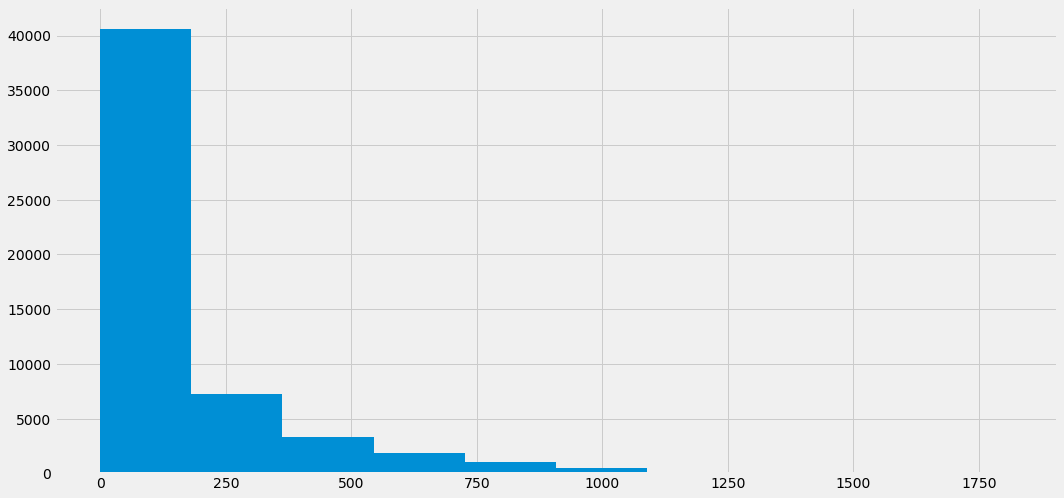

In [18]:
train['text'].str.len().hist()

<AxesSubplot:>

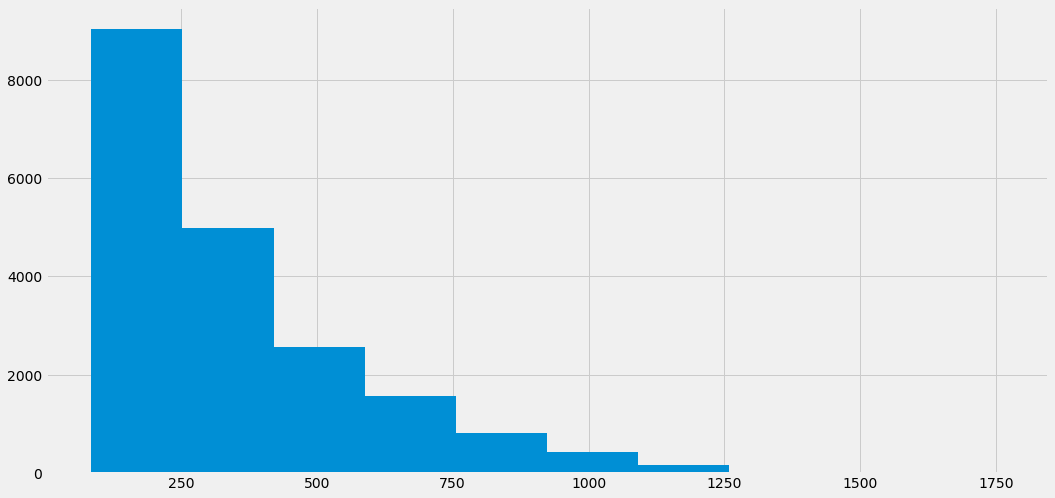

In [19]:
test['text'].str.len().hist()

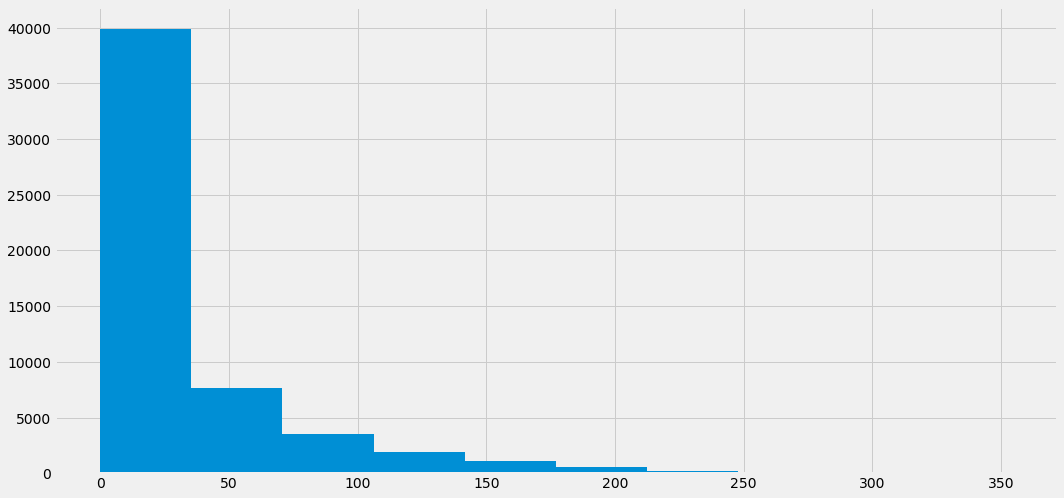

In [34]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

plot_word_number_histogram(train['text'])

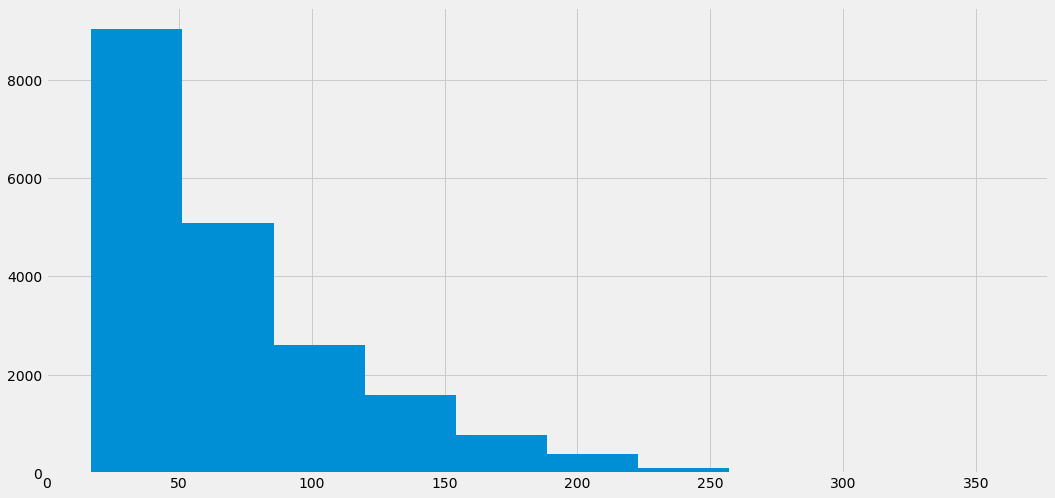

In [35]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

plot_word_number_histogram(test['text'])

In [29]:
X_trn = train['text'].values
X_tst = test['text'].values
y = train['author'].values
print(X_trn.shape, X_tst.shape, y.shape)

(54879,) (19617,) (54879,)


In [46]:
vocab_size = 21000
embedding_dim = 64
max_length = 300
padding_type='post'


In [45]:
#         vocab_size            em_dim            max_length         bacth_size           conv       dense     accuarcy
            32000                128                200                  64               128        64           69
            21000                128                100                  256             128         64           72.03(어케했누?)
            19000                 64                350                  256             256         64           아마 70언저리
            19000                128                150                  256             128         64           얘도 70언저리
            23000                128                110                   64             128         64           70언저리
            20000                128                480                   64             256         64           별로
            20000                 64                500                  128            128,128      64            70.64
            23000                128                180                  256            128,128      64            69.99
            21000                128                130                  256             128         64            71.34   
            30000                128                 60                  256             128         64            별로
            23000                128                 60                  256             128         64            별로
            22000                128                 80                  256             128         64             70언저리
            21000                128                100                  256             128         64             71.54  (drop:0.2 stride:1 )
            21000                 64                300                  512             256         64             72.18 (drop:0.2 stride:1 )

IndentationError: unexpected indent (<ipython-input-45-1aab94bc66a5>, line 2)

In [47]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_trn)
word_index = tokenizer.word_index

In [48]:

train_sequences = tokenizer.texts_to_sequences(X_trn)
test_sequences = tokenizer.texts_to_sequences(X_tst)

In [49]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(54879, 300) (19617, 300)


In [50]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [51]:

def get_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Dropout(0.2),
        Conv1D(256, 3, padding='valid', activation='relu', strides=1),   
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(n_class, activation='softmax')
    ])
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.005))
    return model

In [52]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()    
    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
86/86 [==============================] - 115s 1s/step - loss: 1.1792 - val_loss: 0.8404
Epoch 2/10
86/86 [==============================] - 101s 1s/step - loss: 0.6894 - val_loss: 0.7513
Epoch 3/10
86/86 [==============================] - 99s 1s/step - loss: 0.4899 - val_loss: 0.7746
Epoch 4/10
86/86 [==============================] - 137s 2s/step - loss: 0.3814 - val_loss: 0.8621
Epoch 5/10
86/86 [==============================] - 155s 2s/step - loss: 0.3169 - val_loss: 0.8969
Epoch 00005: early stopping
training model for CV #2
Epoch 1/10
86/86 [==============================] - 151s 2s/step - loss: 1.1882 - val_loss: 0.8518
Epoch 2/10
86/86 [==============================] - 124s 1s/step - loss: 0.7073 - val_loss: 0.7466
Epoch 3/10
86/86 [==============================] - 118s 1s/step - loss: 0.5029 - val_loss: 0.7747
Epoch 4/10
86/86 [==============================] - 143s 2s/step - loss: 0.3820 - val_loss: 0.8438
Epoch 5/10
86/86 [==============

In [53]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')


Accuracy (CV):  72.1897%
Log Loss (CV):   0.7608


In [104]:

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [105]:
print(clf.summary())

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 100, 128)          2688000   
_________________________________________________________________
dropout_52 (Dropout)         (None, 100, 128)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 98, 128)           49280     
_________________________________________________________________
global_max_pooling1d_26 (Glo (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_53 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 5)               

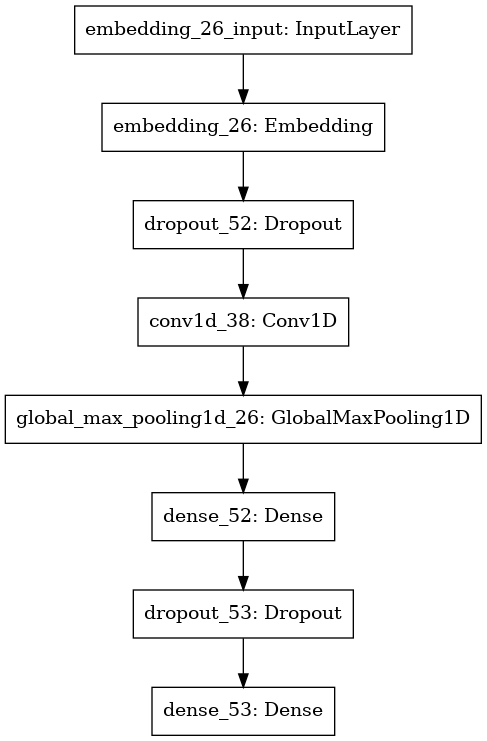

In [106]:
plot_model(clf)

In [107]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [108]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0452,0.5656,0.1726,2.0310e-01,0.0135
1,0.0986,0.2230,0.1811,1.8788e-01,0.3095
2,0.9675,0.0245,0.0016,5.5287e-05,0.0063
3,0.1149,0.0071,0.7309,6.5404e-03,0.1405
4,0.6789,0.0725,0.0477,1.1348e-01,0.0874


In [109]:
sub.to_csv(sub_file)